# Skin Cancer Category Classification

This notebook demonstrates how to build a skin cancer classification model using TensorFlow, Keras, and CNN. The dataset used is the "Skin Cancer MNIST: HAM10000" dataset, which contains images of various types of skin lesions.

## Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import GlobalAveragePooling2D, SpatialDropout2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, SeparableConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Add, Activation

2025-05-19 10:02:18.150753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747663338.166464   63101 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747663338.171383   63101 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 10:02:18.187123: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Meta Data

In [3]:
# Load metadata
df = pd.read_csv("Dataset/HAM10000_metadata.csv")
df['image_path'] = df['image_id'].apply(lambda x: os.path.join("Dataset/HAM10000_images", f"{x}.jpg"))

# Fill missing age with mean
df['age'].fillna(df['age'].mean(), inplace=True)

# Remove rows with unknown or missing sex
df = df[df['sex'].isin(['male', 'female'])].reset_index(drop=True)

# Map dx to labels
label_map = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis-like Lesions',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}
df['label_name'] = df['dx'].map(label_map)

# Filter rows with valid image paths
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)


/tmp/ipykernel_63101/1094393288.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].mean(), inplace=True)


## Original Class Distribution

<Axes: title={'center': 'Original Class Distribution'}, xlabel='label_name'>

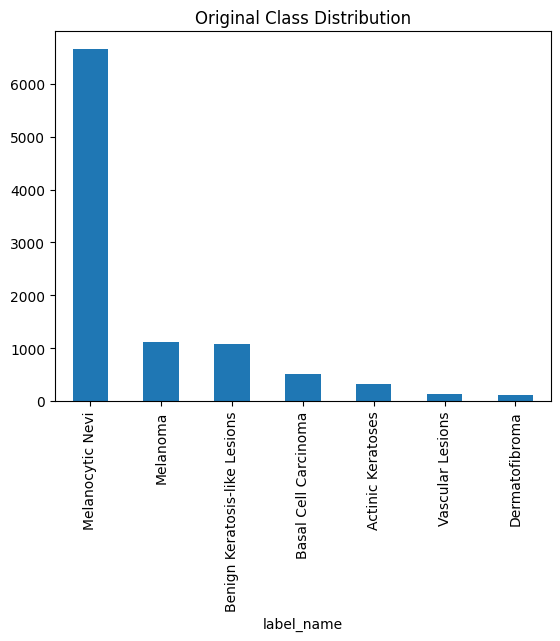

In [4]:
df['label_name'].value_counts().plot(kind='bar', title='Original Class Distribution')

## Balance Dataset by Undersampling 'nv'

<Axes: title={'center': 'Balanced Class Distribution'}, xlabel='label_name'>

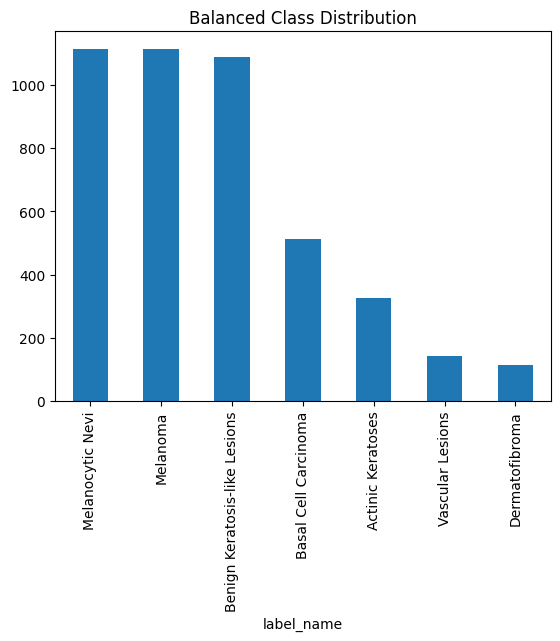

In [3]:
# Check class counts based on label_name
class_counts = df['label_name'].value_counts()

# Undersample 'Melanocytic Nevi' to match the largest non-'nv' class
min_class_size = class_counts.drop('Melanocytic Nevi').max()

# Create balanced dataframe
balanced_df = pd.concat([
    df[df['label_name'] == 'Melanocytic Nevi'].sample(min_class_size, random_state=42),
    *[df[df['label_name'] == cls] for cls in class_counts.index if cls != 'Melanocytic Nevi']
]).reset_index(drop=True)

# Show resulting class distribution
balanced_df['label_name'].value_counts().plot(kind='bar', title='Balanced Class Distribution')

In [4]:
balanced_df['label_name'].value_counts()

label_name
Melanocytic Nevi                 1113
Melanoma                         1113
Benign Keratosis-like Lesions    1089
Basal Cell Carcinoma              514
Actinic Keratoses                 327
Vascular Lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64

## Load Images and Tabular Features

In [5]:
IMAGE_SIZE = 224

def load_and_resize(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    return np.array(img)

X_img = []
X_tabular = []
y = []

for _, row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
    try:
        X_img.append(load_and_resize(row['image_path']))
        X_tabular.append([row['age'], row['sex'], row['localization']])
        y.append(row['label_name'])
    except:
        continue

X_img = np.array(X_img, dtype=np.float32) / 255.0  # normalize images


100%|██████████| 4413/4413 [00:30<00:00, 146.29it/s]


## Augmentation for Rare Classes

In [6]:
# Define target augmentations per class
augment_needed = {
    'Dermatofibroma': 500,
    'Vascular Lesions': 500,
    'Actinic Keratoses': 600,
    'Basal Cell Carcinoma': 400,
    'Benign Keratosis-like Lesions' : 50
}

# Augmentation configuration
augmentor = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

augmented_imgs = []
augmented_tabs = []
augmented_labels = []

# Loop over each class to augment
for cls, need in augment_needed.items():
    orig_indices = [i for i, label in enumerate(y) if label == cls]
    per_image = math.ceil(need / len(orig_indices))

    for idx in orig_indices:
        img = X_img[idx].reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))  # 4D
        tab = X_tabular[idx]
        aug_iter = augmentor.flow(img, batch_size=1)

        for _ in range(per_image):
            if augmented_labels.count(cls) >= need:
                break
            aug_img = next(aug_iter)[0] / 255.0  # Normalize if needed
            augmented_imgs.append(aug_img)
            augmented_tabs.append(tab)
            augmented_labels.append(cls)

# Convert to arrays where appropriate
X_aug = np.array(augmented_imgs, dtype=np.float32)
X_tab_aug = augmented_tabs  # remains a list of lists
y_aug = augmented_labels

# Merge with original
X_img = np.concatenate([X_img, X_aug], axis=0)
X_tabular += X_tab_aug
y += y_aug

<Axes: title={'center': 'Class Distribution After Augmentation'}>

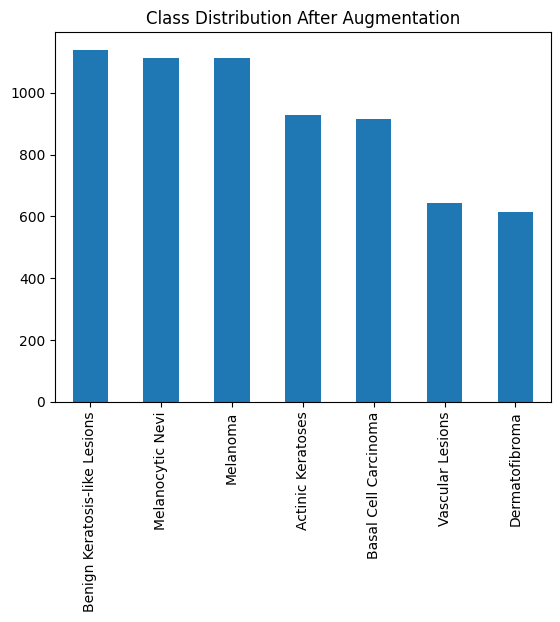

In [7]:
pd.Series(y).value_counts().plot(kind='bar', title='Class Distribution After Augmentation')

In [8]:
pd.Series(y).value_counts()

Benign Keratosis-like Lesions    1139
Melanocytic Nevi                 1113
Melanoma                         1113
Actinic Keratoses                 927
Basal Cell Carcinoma              914
Vascular Lesions                  642
Dermatofibroma                    615
Name: count, dtype: int64

## Tabular Processing & Label Encoding

In [9]:
meta_df = pd.DataFrame(X_tabular, columns=['age', 'sex', 'localization'])

# Tabular pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['age']),
    ('cat', OneHotEncoder(), ['sex', 'localization'])
])

X_meta = preprocessor.fit_transform(meta_df).astype(np.float32)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Shuffle and stratified split
X_img, X_meta, y_categorical = shuffle(X_img, X_meta, y_categorical, random_state=42)

X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    X_img, X_meta, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42
)

In [10]:
# Confirm class distribution
pd.Series(np.argmax(y_train, axis=1)).value_counts(normalize=True)

2    0.176209
4    0.172147
5    0.171180
1    0.144487
0    0.141586
3    0.097679
6    0.096712
Name: proportion, dtype: float64

In [11]:
# Inspect the metadata preprocessing pipeline to see exactly which categories are encoded

# 1. Show which columns are being transformed
print("Numeric columns:", preprocessor.transformers_[0][2])
print("Categorical columns:", preprocessor.transformers_[1][2])

# 2. Show the categories for each categorical column
ohe = preprocessor.named_transformers_['cat']
cat_cols = preprocessor.transformers_[1][2]
for col, cats in zip(cat_cols, ohe.categories_):
    print(f"{col} categories ({len(cats)}): {cats}")

# 3. Show the total number of metadata features after transform
dummy_meta = meta_df.head(1)
transformed = preprocessor.transform(meta_df.head(1))
print("Transformed metadata shape:", transformed.shape)

Numeric columns: ['age']
Categorical columns: ['sex', 'localization']
sex categories (2): ['female' 'male']
localization categories (15): ['abdomen' 'acral' 'back' 'chest' 'ear' 'face' 'foot' 'genital' 'hand'
 'lower extremity' 'neck' 'scalp' 'trunk' 'unknown' 'upper extremity']
Transformed metadata shape: (1, 18)


## Custom CNN Dual Input Model

In [12]:
def build_dual_input_model(img_shape, meta_shape, num_classes):
    # ---------- Image input branch ----------
    img_input = Input(shape=img_shape)

    x = SeparableConv2D(32, (3, 3), padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2, 2)(x)

    x = SeparableConv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2, 2)(x)

    x = SeparableConv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2, 2)(x)

    x = SeparableConv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2, 2)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)

    # ---------- Metadata input branch ----------
    meta_input = Input(shape=(meta_shape,))
    m = Dense(128, activation='relu')(meta_input)
    m = Dropout(0.3)(m)
    m = Dense(64, activation='relu')(m)
    m = Dropout(0.2)(m)
    m = Dense(64, activation='relu')(m)

    # ---------- Merge via Add() ----------
    fused = Add()([x, m])
    z = Dense(128, activation='relu')(fused)
    z = Dropout(0.3)(z)
    z = Dense(64, activation='relu')(z)
    z = Dense(num_classes, activation='softmax')(z)

    return Model(inputs=[img_input, meta_input], outputs=z)

In [13]:
model = build_dual_input_model(
    img_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    meta_shape=X_meta.shape[1],
    num_classes=y_categorical.shape[1]
)

I0000 00:00:1747590739.665826   35727 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 224, 224,  │        155 │ input_layer[0][0] │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 112, 112,  │      2,400 │ max_pooling2d[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 56, 56,    │      8,896 │ max_pooling2d_1[… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 28, 28,    │     34,176 │ max_pooling2d_2[… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 18)        │          0 │ -               

 Total params: 120,578 (471.01 KB)

 Trainable params: 119,618 (467.26 KB)

 Non-trainable params: 960 (3.75 KB)

## Compile and Train the Model

In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

history = model.fit(
    [X_img_train, X_meta_train],
    y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

2025-05-18 13:52:48.503341: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2801627136 exceeds 10% of free system memory.
2025-05-18 13:52:50.839988: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2801627136 exceeds 10% of free system memory.


Epoch 1/50


I0000 00:00:1747590777.066021   36172 service.cc:148] XLA service 0x7f3c1c01f220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747590777.066199   36172 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2025-05-18 13:52:57.204397: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747590777.795689   36172 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-18 13:52:59.853028: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3396', 60 bytes spill stores, 64 bytes spill loads

2025-05-18 13:52:59.870061: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3396

  2/146 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.1641 - loss: 2.0352 

I0000 00:00:1747590789.313093   36172 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - accuracy: 0.3204 - loss: 1.6613 - val_accuracy: 0.2669 - val_loss: 1.7390 - learning_rate: 0.0010
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4886 - loss: 1.3048 - val_accuracy: 0.2611 - val_loss: 1.6877 - learning_rate: 0.0010
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5155 - loss: 1.2316 - val_accuracy: 0.3907 - val_loss: 1.4855 - learning_rate: 0.0010
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5409 - loss: 1.1759 - val_accuracy: 0.4836 - val_loss: 1.3198 - learning_rate: 0.0010
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5621 - loss: 1.1312 - val_accuracy: 0.5803 - val_loss: 1.0849 - learning_rate: 0.0010
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5640 - loss: 1.1058 - val_accuracy: 0.5048 - val_loss: 1.3159 - learning_rate: 0.0010
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5644 - loss: 1.1167 - va

## Evaluate the Model on Test Set

In [16]:
# Evaluate accuracy
loss, acc = model.evaluate([X_img_test, X_meta_test], y_test)
print(f"Test Accuracy: {acc:.4f}")

# Predict labels
y_pred = model.predict([X_img_test, X_meta_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Decode labels for report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6505 - loss: 0.8679
Test Accuracy: 0.6558
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
                               precision    recall  f1-score   support

            Actinic Keratoses       0.62      0.58      0.60       195
         Basal Cell Carcinoma       0.54      0.68      0.60       167
Benign Keratosis-like Lesions       0.60      0.58      0.59       228
               Dermatofibroma       0.61      0.80      0.69       110
             Melanocytic Nevi       0.77      0.74      0.75       223
                     Melanoma       0.67      0.66      0.66       228
             Vascular Lesions       0.86      0.61      0.71       142

                     accuracy                           0.66      1293
                    macro avg       0.67      0.66      0.66      1293
                 weighted avg       0.67      0.66      0.66      1293



## Confusion Matrix

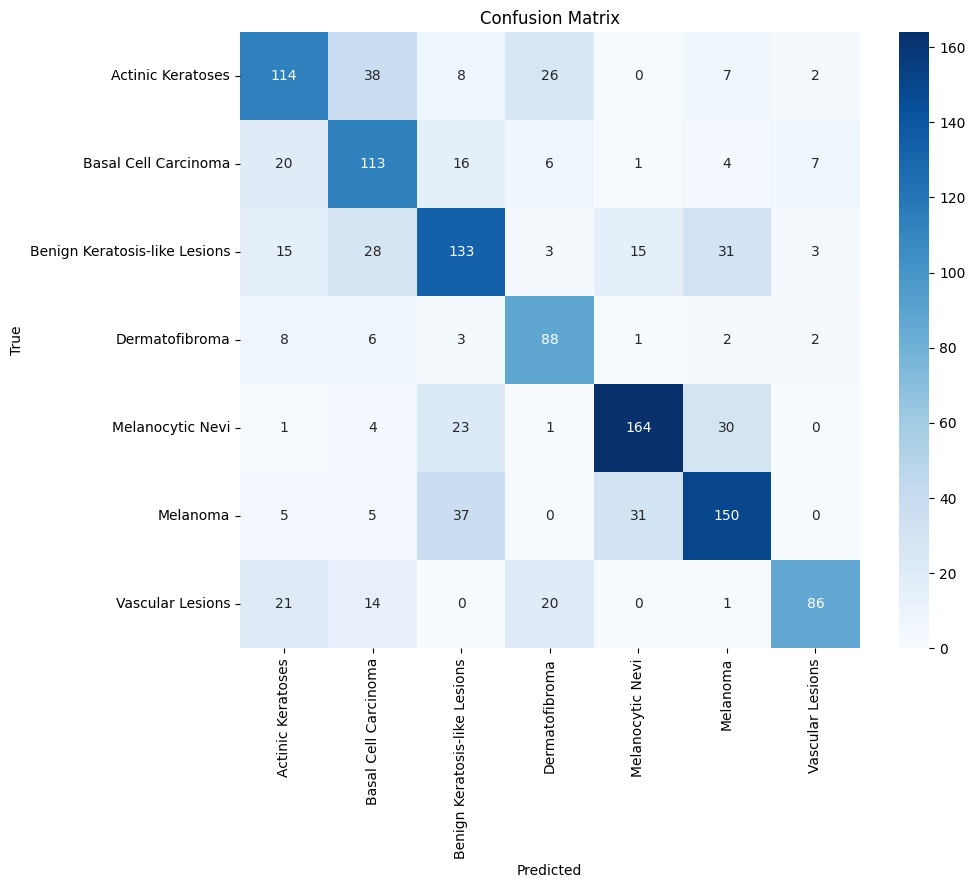

In [17]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Training History

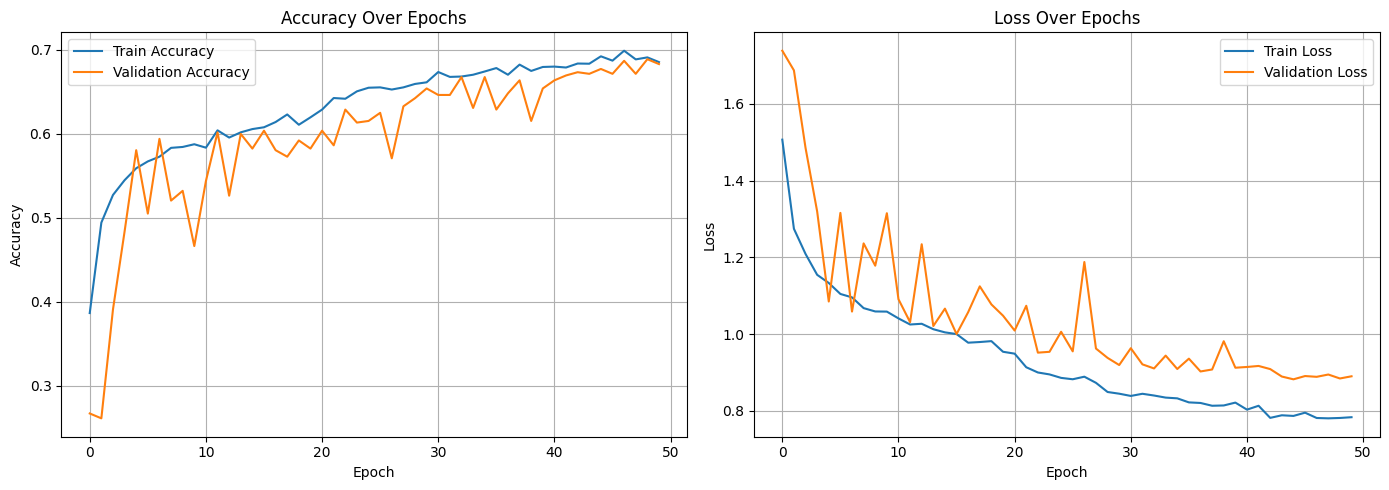

In [18]:
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Export to ONNX

In [ ]:
#import tf2onnx
#import tensorflow as tf
#
#spec = (
#    tf.TensorSpec([None, IMAGE_SIZE, IMAGE_SIZE, 3], tf.float32, name="image_input"),
#    tf.TensorSpec([None, X_meta.shape[1]], tf.float32, name="meta_input")
#)
#
## Convert the Keras model to ONNX
#model_proto, _ = tf2onnx.convert.from_keras(
#    model,
#    input_signature=spec,
#    opset=13,
#    output_path="Models/SKIN_69.onnx"
#)